# Построение линейной модели для предсказания температуры воздуха в Санкт-Петербурге
## Выполнил Старинчиков Владимир

### Импортируем библиотеки

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
from datetime import datetime
from statsmodels.formula.api import ols
from scipy.optimize import curve_fit

#### Задаем параметры для подключения к **API** [meteostat.net](meteostat.net) для получения данных с Питерской метео вышки

In [3]:
api_key = '48aaef5c1amsh742439722462139p1c30d6jsn6d124ab21f82'

url = 'https://meteostat.p.rapidapi.com/stations/daily'

params = {
    'station': '26063',
    'start': '2019-01-01',
    'end': '2023-12-31'
}

headers = {
    'x-rapidapi-host': 'meteostat.p.rapidapi.com',
    'x-rapidapi-key': api_key
}

#### Отправляем запрос и записываем ответ в переменную **data**

In [4]:
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()
else:
    print(f"Ошибка: {response.status_code}")

#### Запись ответа в ``pd.DataFrame`` для более удобного взаимодействия

In [5]:
df = pd.DataFrame(data['data'])
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'tavg']]
df

,date,tavg
0,2019-01-01,-0.8
1,2019-01-02,0.2
2,2019-01-03,-3.1
3,2019-01-04,-6.7
4,2019-01-05,-5.1
...,...,...
1821,2023-12-27,-4.5
1822,2023-12-28,-3.3
1823,2023-12-29,-2.8
1824,2023-12-30,-3.9


#### Генерация посезонных DataFrame-ов для дальнейшего анализа

In [6]:
winter_df = df[df['date'].dt.month.isin([1, 2])]
december_df = df[df['date'].dt.month == 12]
spring_df = df[df['date'].dt.month.isin([3, 4, 5])]
summer_df = df[df['date'].dt.month.isin([6, 7, 8])]
fall_df = df[df['date'].dt.month.isin([9, 10, 11])]

#### Генерация годовых DataFrame-ов для дальнейшего анализа

In [7]:
df_2019 = df[df['date'].dt.year == 2019]
df_2020 = df[df['date'].dt.year == 2020]
df_2021 = df[df['date'].dt.year == 2021]
df_2022 = df[df['date'].dt.year == 2022]
df_2023 = df[df['date'].dt.year == 2023]

#### Построение годовых и общего графиков изменения температур c полезной информацией

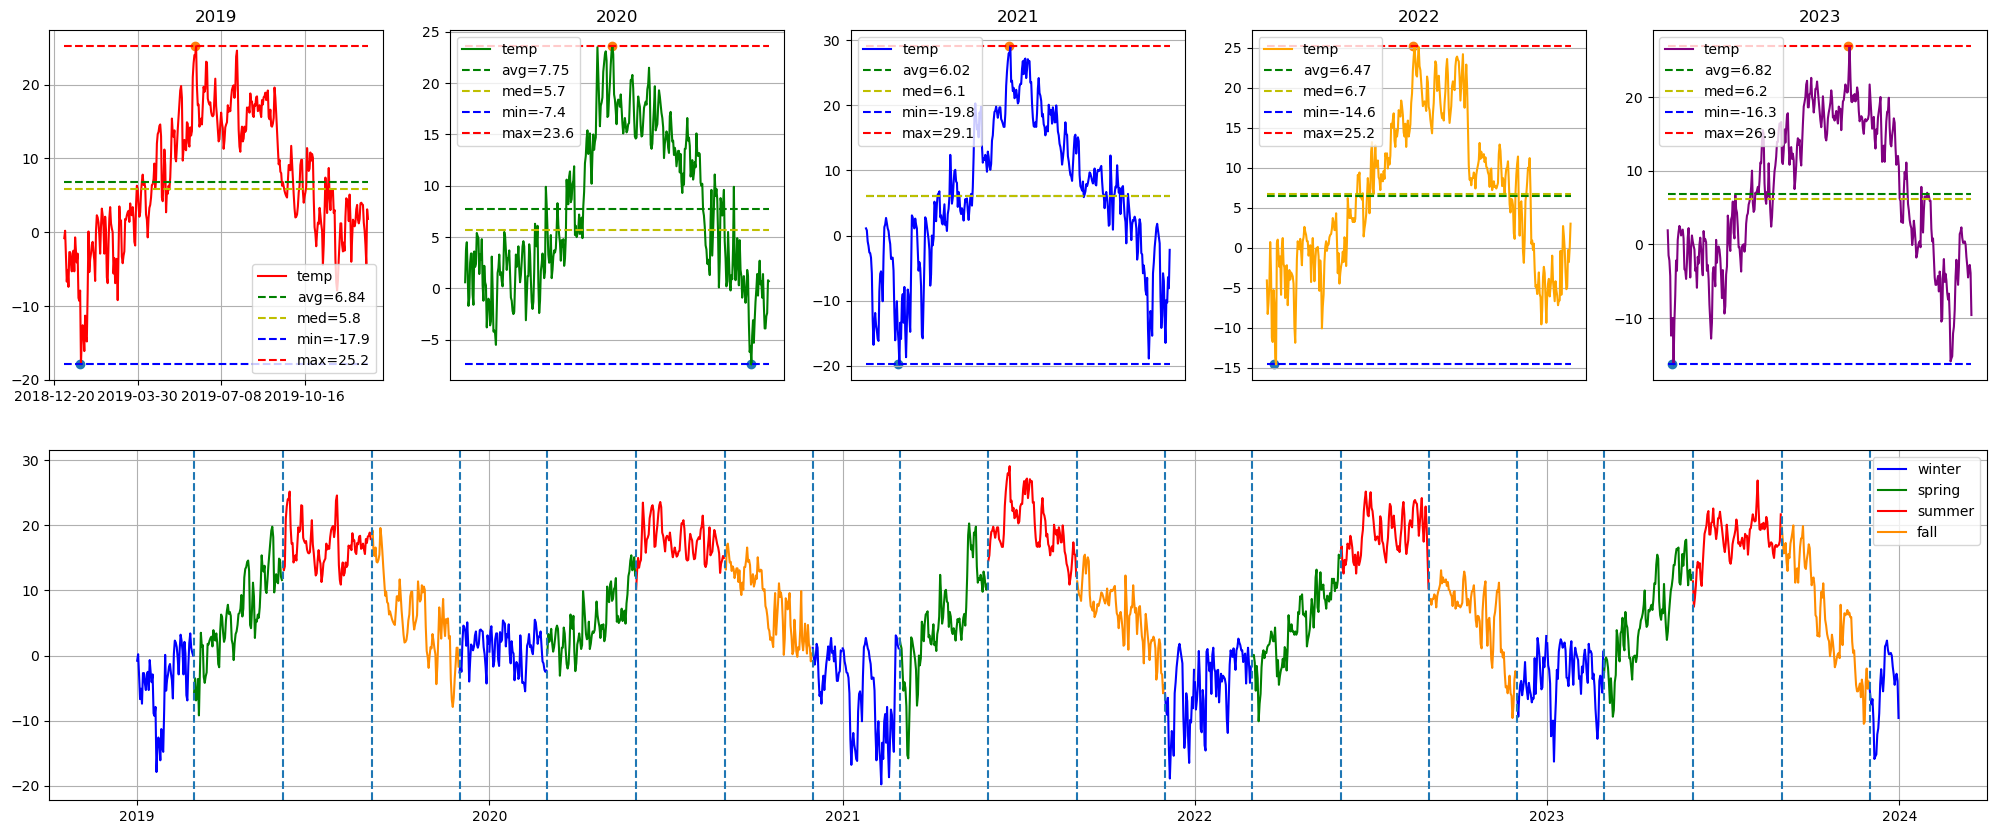

In [8]:
plt.figure(figsize=(25, 10))

for i, year in enumerate([df_2019, df_2020, df_2021, df_2022, df_2023]):
    plt.subplot(2, 5, i + 1)
    c = ('r', 'g', 'b', 'orange', 'purple')[i]
    plt.plot(year['date'], year['tavg'], c=c, label='temp')
    plt.plot(year['date'], np.full(year['date'].size, year['tavg'].mean()), '--g', label=f'avg={year['tavg'].mean().round(2)}')
    plt.plot(year['date'], np.full(year['date'].size, year['tavg'].median()), '--y', label=f'med={round(year['tavg'].median(), 2)}')
    plt.plot(year['date'], np.full(year['date'].size, year['tavg'].min()), '--b', label=f'min={year['tavg'].min()}')
    plt.plot(year['date'], np.full(year['date'].size, year['tavg'].max()), '--r', label=f'max={year['tavg'].max()}')
    plt.scatter(np.where(year['tavg'] == year['tavg'].min())[0][0] + (2019 + i - 1970) * 365 + 11, year['tavg'].min())
    plt.scatter(np.where(year['tavg'] == year['tavg'].max())[0][0] + (2019 + i - 1970) * 365 + 11, year['tavg'].max())
    plt.legend()
    plt.title(f'{2019 + i}')
    plt.grid()
    plt.xticks(np.arange(((2019 + i - 1970) * 365), (2020 - 1970) * 365, 100.0))

#
plt.subplot(2, 1, 2)
plt.grid()
for i in range(5):
    winter_current_year = winter_df[winter_df['date'].dt.year == 2019 + i]
    plt.plot(winter_current_year.date, winter_current_year.tavg, 'b', label='winter')
    
    december_current_year = december_df[december_df['date'].dt.year == 2019 + i]
    plt.plot(december_current_year.date, december_current_year.tavg, 'b')
    
    spring_current_year = spring_df[spring_df['date'].dt.year == 2019 + i]
    plt.plot(spring_current_year.date, spring_current_year.tavg, 'g', label='spring')

    summer_current_year = summer_df[summer_df['date'].dt.year == 2019 + i]
    plt.plot(summer_current_year.date, summer_current_year.tavg, 'r', label='summer')

    fall_current_year = fall_df[fall_df['date'].dt.year == 2019 + i]
    plt.plot(fall_current_year.date, fall_current_year.tavg, '#FF8C00', label='fall')

    if not i:
        plt.legend()
    
    plt.axvline(df[(df['date'].dt.year == 2019 + i) & (df['date'].dt.month == 3) & (df['date'].dt.day == 1)]['date'], ls='--')
    plt.axvline(df[(df['date'].dt.year == 2019 + i) & (df['date'].dt.month == 6) & (df['date'].dt.day == 1)]['date'], ls='--')
    plt.axvline(df[(df['date'].dt.year == 2019 + i) & (df['date'].dt.month == 9) & (df['date'].dt.day == 1)]['date'], ls='--')
    plt.axvline(df[(df['date'].dt.year == 2019 + i) & (df['date'].dt.month == 12) & (df['date'].dt.day == 1)]['date'], ls='--')

#### Анализ распределения температур

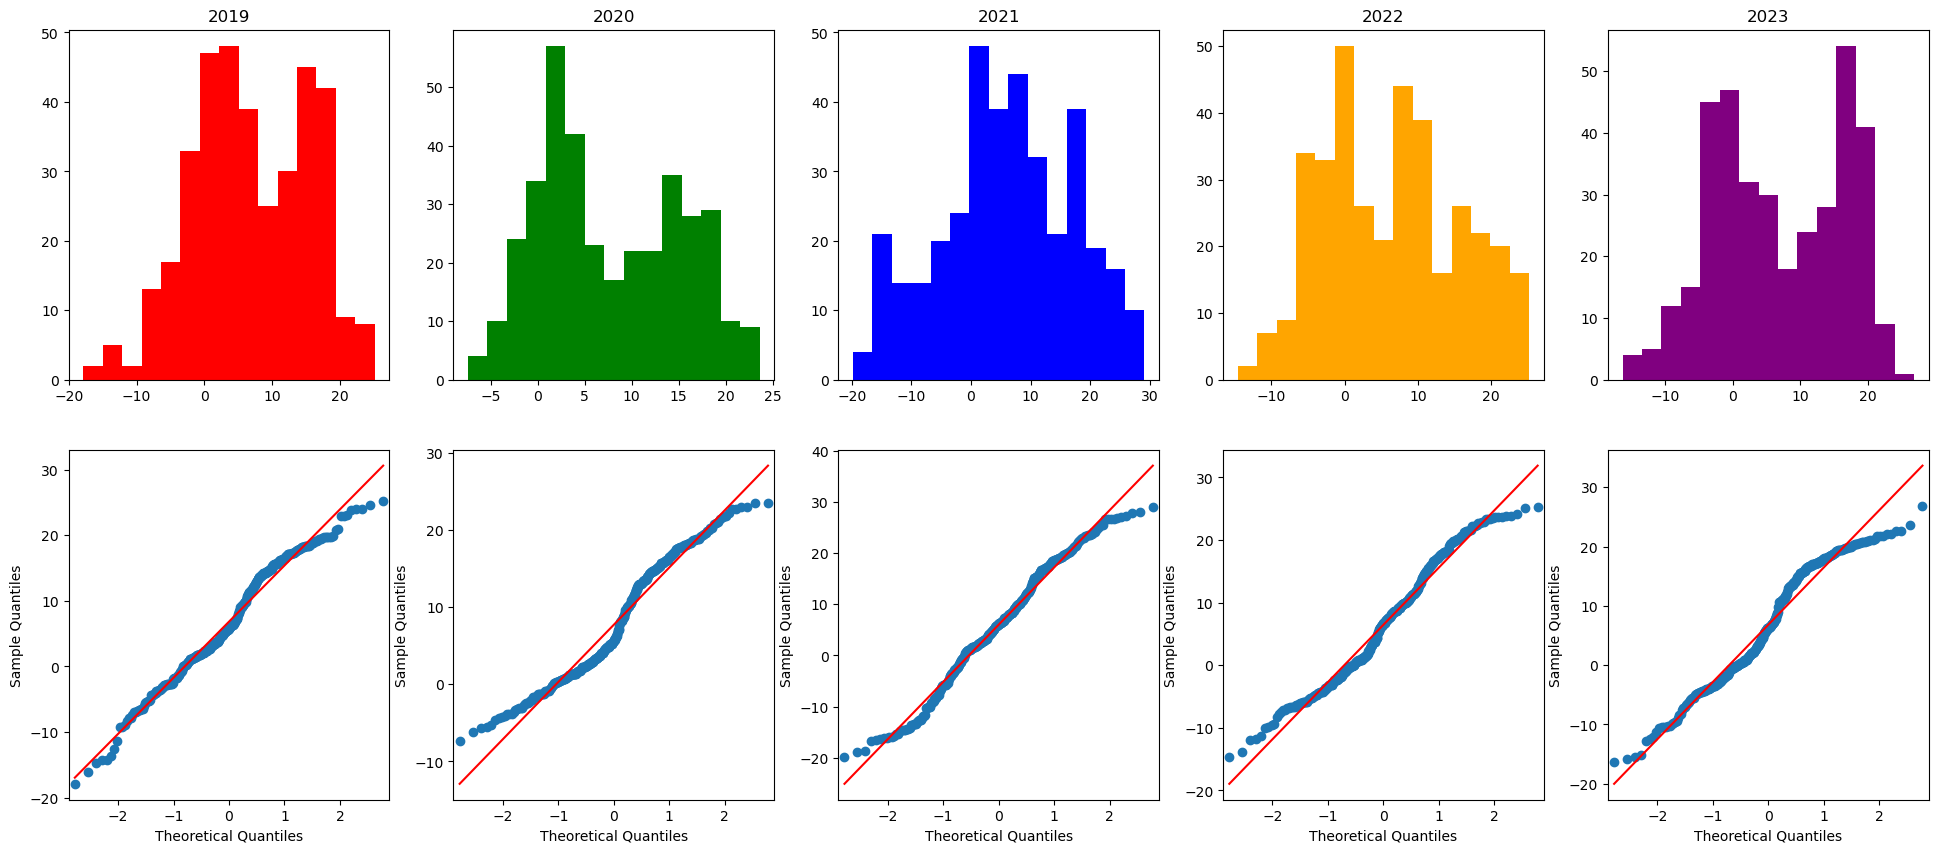

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(24, 10))
ax[0, 0].hist(df_2019.tavg, bins=15, color='r')
ax[0, 0].set_title('2019')

ax[0, 1].hist(df_2020.tavg, bins=15, color='g', )
ax[0, 1].set_title('2020')

ax[0, 2].hist(df_2021.tavg, bins=15, color='b')
ax[0, 2].set_title('2021')

ax[0, 3].hist(df_2022.tavg, bins=15, color='orange')
ax[0, 3].set_title('2022')

ax[0, 4].hist(df_2023.tavg, bins=15, color='purple')
ax[0, 4].set_title('2023')

sm.qqplot(df_2019.tavg, line='s', ax=ax[1, 0])
sm.qqplot(df_2020.tavg, line='s', ax=ax[1, 1])
sm.qqplot(df_2021.tavg, line='s', ax=ax[1, 2])
sm.qqplot(df_2022.tavg, line='s', ax=ax[1, 3])
sm.qqplot(df_2023.tavg, line='s', ax=ax[1, 4])

plt.show()

#### Делаем вывод, что распределение относительно нормально в каждом году

#### Проведем ANOVA тест чтобы узнать, различаются ли средние значения температуры в годах

In [10]:
df['year'] = df['date'].dt.year
df_anova = df[['year', 'tavg']]

model = ols('tavg ~ C(year)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df         F    PR(>F)
C(year)      591.900044     4.0  1.711655  0.144727
Residual  157428.018209  1821.0       NaN       NaN


#### ANOVA тест показал, что **p_value** более **0.1**, что говорит об отсутствии взаимосвязи между температурами и годом измерения. Всего 591 из 150к+ пунктов объясняются межгодовыми различиями

#### Сделав вывод о независимости температуры от года измерения, построим математическую модель для описания и предсказания данных.
#### Реализуем алгоритм линейной регрессии и оптимизации параметров при помощи градиентного спуска.

Optimized parameters: w0 = 6.625643186327569, w1 = 58.90735543984774, w2 = -11.722931714803506


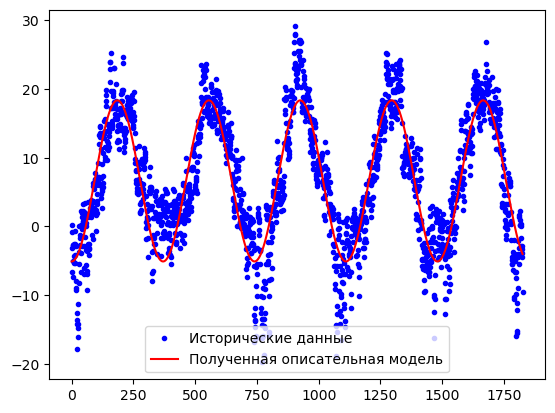

In [11]:
x = np.arange(0, len(df))
y = df['tavg'].values
step = 0.01
epsilon = 0.0001
w = [1, 60, 5]

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

for i in range(10000): 
    y_pred = w[2] * np.cos((1 / w[1]) * x) + w[0]
    
    dw0 = -2 * np.mean(y - y_pred)
    dw1 = -2 * np.mean((y - y_pred) * w[2] * np.sin((1 / w[1]) * x) * x / (w[1]**2 + 1e-6))
    dw2 = -2 * np.mean((y - y_pred) * np.cos((1 / w[1]) * x))
    
    w[0] -= step * dw0
    w[1] -= step * dw1
    w[2] -= step * dw2

    if mse_loss(y, y_pred) < epsilon:
        print(f'Converged after {i+1} iterations')
        break

x_pred = np.arange(len(df))
y_pred = w[2] * np.cos((1 / w[1]) * x_pred) + w[0]

print(f'Optimized parameters: w0 = {w[0]}, w1 = {w[1]}, w2 = {w[2]}')

plt.plot(x, y, 'b.', label='Исторические данные')
plt.plot(x_pred, y_pred, 'r', label='Полученная описательная модель')
plt.legend()
plt.show()

#### Повторим функционал при помощи пакета ``scipy``

Оптимальные параметры: w0 = 6.625642896199997, w1 = 58.90735700313937, w2 = -11.722931827618554


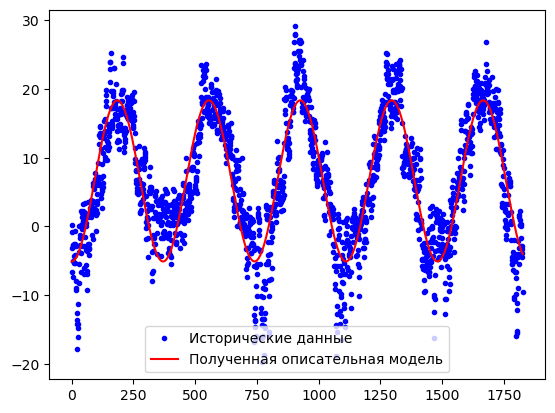

In [12]:
x = np.arange(0, len(df))
y = df['tavg'].values

def model_func(x, w0, w1, w2):
    return w2 * np.cos((1 / w1) * x) + w0

initial_guess = [1, 60, 5]

params, covariance = curve_fit(model_func, x, y, p0=initial_guess)

w0, w1, w2 = params
print(f'Оптимальные параметры: w0 = {w0}, w1 = {w1}, w2 = {w2}')

x_pred = np.arange(len(df))
y_pred = model_func(x_pred, w0, w1, w2)

plt.plot(x, y, 'b.', label='Исторические данные')
plt.plot(x_pred, y_pred, 'r', label='Полученная описательная модель')
plt.legend()
plt.show()

### Итог: параметры сошлись, теперь на основе этих параметров и приближенной формуле можно строить предсказания погодных условий
#### Попробуем предсказать погоду на выбранную дату

In [13]:
current_date = datetime.strptime('2024-10-01', '%Y-%m-%d')
first_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
x_value = (current_date - first_date).days
print(model_func(x_value, w[0], w[1], w[2]))
print(model_func(x_value, w0, w1, w2))

12.029866663862329
12.029876267595494


#### Средняя температура воздуха на сегодня составляет **+16°**, учитывая аномально жаркую осень, можно сказать, что описательная модель работает приемлимо